In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from Code.GDTW import gromov_dtw 
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from imageio import imread
import sklearn

# Defining the Expert Policy $y_{exp}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def twospirals(linspace,n_points, noise=.01):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(linspace.reshape(-1,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return np.hstack((d1x,d1y))+1
    

y_exp=twospirals((torch.exp(torch.linspace(0,1.42,35))-1)/3.13,35,0)/20
y_exp=torch.tensor(y_exp)


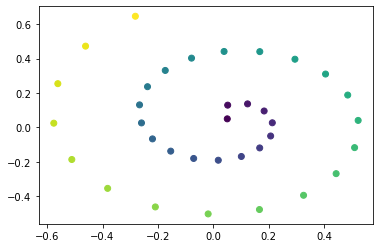

In [3]:
plt.scatter(y_exp[:,0],y_exp[:,1], c = np.arange(len(y_exp)))

# Defining the Actor's artitecture $\pi_{\theta}$

In [4]:

class MLP(nn.Module):

        def __init__(self,state_dim=2,hidden_dim=128,action_dim=2):
            super(MLP, self).__init__()

            main = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(True),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(True),
                nn.Linear(hidden_dim, action_dim),
            )
            self.main = main

        def forward(self, state):

            output = self.main(state)
            return output

# Performing rollouts $x_\theta \in \mathcal{X}^T$ under the current policy $\pi_\theta$ starting at $ x_0$

Agent rollouts under the current policy $\pi_\theta$ and transition dynamics $\mathcal{T}$, and starting at $x_\theta^{(0)}$ are generated in the following way:

$$\forall t=1,...,T: a_t = \pi_{\theta}(x_\theta^{(t)}), \quad x_\theta^{(t+1)}= \mathcal{T}(x_\theta^{(t)},a_t)$$




In [5]:
def rollout(x0,actor,episode_len):
    state=x0
    states=state
    
    for step in range(episode_len):
        action = actor(state)
        new_state=action+state
        states = torch.cat((states,new_state),0) 
        state=new_state
        
        
    return(states)

# Experimental setup

In [6]:
num_epochs=6000

#Length of rollouts T
episode_len=37

#Defining the policy $|pi_\theta$'s architecture and optimizer
actor=MLP(state_dim=2,hidden_dim=64,action_dim=2)
optimizer = torch.optim.Adam(actor.parameters(), lr=5e-5, betas=(0.5, 0.99))

#Defining the distance GDTW
GDTW = gromov_dtw(max_iter=10,gamma=0.1,loss_only=1,dtw_approach='soft_GDTW',verbose=0)

#Defining the agent's initial location (the same as the expert's initial location here)
x0=y_exp[0].reshape(1,-1).float()

# Training the model

Here, we train the model by minimizing the GDTW between the expert trajectory $y_{exp}$ and the agent's rollout $x_\theta$ w.r.t the agent policy $\pi_\theta$'s parameters, namely:

$$\min_{\theta}\text{GDTW}(y_{exp},x_\theta)$$

In [7]:

episode_rewards = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    new_episode = rollout(x0,actor,episode_len)


    loss = GDTW(new_episode,y_exp)

    loss.backward()
    optimizer.step()


    episode_rewards.append(loss.item())
    
    if epoch%500==0:

        print('GDTW to ground truth',loss.item())


GDTW to ground truth 66998868.0
GDTW to ground truth 16666.67578125
GDTW to ground truth 1108.6484375
GDTW to ground truth 303.228759765625
GDTW to ground truth 180.45486450195312
GDTW to ground truth 140.47142028808594
GDTW to ground truth 6.091541290283203
GDTW to ground truth 4.778125286102295
GDTW to ground truth 3.913471221923828
GDTW to ground truth 3.239980459213257
GDTW to ground truth 3.099473476409912
GDTW to ground truth 2.9121103286743164


# Plotting a rollout $x_\theta$ under the learned policy $\pi_\theta$ and comparing to the expert's $\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad$ rollout $y_{exp}$

We note that the learned policy has to be equivalent up to isometry (translations/rotations/reflections). We therefore observe in the following plot that the expert trajectory is recovered but up to some rotation of the ground space.

Text(0.5, 1.0, 'Rollout under expert policy')

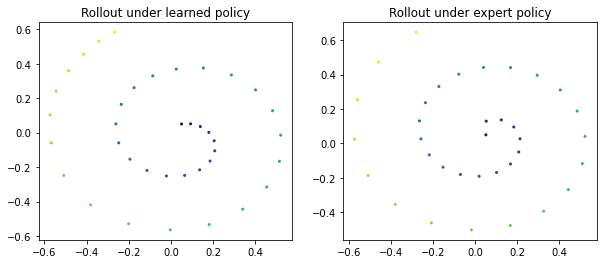

In [9]:
fig,ax=plt.subplots(1,2,figsize=[10,4])

roll=rollout(x0,actor,episode_len)

ax[0].scatter(roll.detach()[:,0],roll.detach()[:,1],c=np.arange(len(roll)),s=4)
ax[0].set_title('Rollout under learned policy')

ax[1].scatter(y_exp[:,0],y_exp[:,1],c=np.arange(len(y_exp)),s=4)
ax[1].set_title('Rollout under expert policy')